In [45]:
# Insira sua resposta aqui
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt
#!pip install yellowbrick
from yellowbrick.regressor import ResidualsPlot
import seaborn as sns
sns.set()
from fbprophet import Prophet
from xgboost import XGBRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
from sklearn import linear_model
import sklearn.metrics as metrics
from scipy.stats import zscore
sns.set()

In [46]:
comp_price = pd.read_csv('test_prc/comp_prices.csv', sep=',')
sales = pd.read_csv('test_prc/sales.csv', sep=',')

# B2W Challange

The sales.csv file contains transactional information where each line represents a sale. The comp_prices.csv file contains monitoring data of competitors’ prices. We have data available for 6 competitors, C1 to C6, which are monitored twice per day. The information below describes the data in each column:

- **PROD_ID**: Product ID. We provide data for 9 different products, P1 to P9;
- **DATE_ORDER**: Sales Date, under YYYY-MM-DD format;
- **QTY_ORDER*: Quantity Sold;
- **REVENUE**: Sale revenue. There can be variations of the price for the same product, depending on the sales channel or discounts, which are applied to the base price;
- **DATE_EXTRACTION**: Date and Time of the extraction of the competitors’ price, under YYYY-MM-DD HH:MM:SS format;
- **COMPETITOR**: Competitors’ ID (C1 to C6);
- **COMPETITOR_PRICE**: Competitors’ price per product, which can depend on the payment method;
- **PAY_TYPE**: Payment Method (1=deferred payment, 2=immediate payment).

1) Models for Demand Forecasting: The main objective is to create a model to predict the quantity sold for each product given a prescribed price. Along with the statistical model, we need metrics, relationships and descriptions of these data in order to understand the sales behavior. What does the data tell us? How are the different data sources related? Is there a particular competitor that seems more important?

2) Presentation of the results: we want to know what were the steps and your strategy (approach to the problem) during the analysis, even if these may seem wrong. The process you went through and the reasoning behind it, is as important as the solutions you found. For this, please prepare a clear and objective presentation to explain both your methodology and your results. In case you are selected for the interview, you will need to make a 20-minute (max) presentation.

In [47]:
sales['DATE_ORDER'] = pd.to_datetime(sales['DATE_ORDER'])
comp_price['DATE_EXTRACTION_DAY'] = pd.to_datetime(comp_price['DATE_EXTRACTION'].str.split(' ').str[0])
comp_price['DATE_EXTRACTION'] = pd.to_datetime(comp_price['DATE_EXTRACTION'])

In [48]:
sales

,PROD_ID,DATE_ORDER,QTY_ORDER,REVENUE
0,P6,2015-08-02,1.0,1808.99
1,P6,2015-08-17,1.0,1674.00
2,P6,2015-08-17,1.0,1673.95
3,P6,2015-08-11,1.0,1674.00
4,P6,2015-08-17,1.0,1674.00
...,...,...,...,...
351086,P3,2015-09-24,1.0,1008.83
351087,P3,2015-10-13,2.0,2333.92
351088,P3,2015-09-24,1.0,1311.81
351089,P3,2015-10-13,1.0,1166.96


In [49]:
comp_price

,PROD_ID,DATE_EXTRACTION,COMPETITOR,COMPETITOR_PRICE,PAY_TYPE,DATE_EXTRACTION_DAY
0,P6,2015-01-30 08:11:38,C3,1898.00,1,2015-01-30
1,P6,2015-01-30 08:11:38,C1,1898.00,1,2015-01-30
2,P6,2015-01-30 08:11:38,C6,1999.90,1,2015-01-30
3,P6,2015-01-31 20:10:14,C2,1894.88,2,2015-01-31
4,P6,2015-01-31 20:10:14,C3,1894.88,2,2015-01-31
...,...,...,...,...,...,...
50109,P5,2015-10-11 20:10:34,C1,819.00,2,2015-10-11
50110,P5,2015-10-11 20:10:34,C2,853.52,2,2015-10-11
50111,P5,2015-10-12 08:11:27,C2,853.52,1,2015-10-12
50112,P5,2015-10-12 08:11:27,C3,819.00,1,2015-10-12


## Sales Agg by min revenue

In [50]:
sales_agg = sales.groupby(['PROD_ID','DATE_ORDER']).agg({'QTY_ORDER': ['sum'], 'REVENUE': ['min']}).reset_index()
sales_agg.columns = sales_agg.columns.get_level_values(0)
sales_agg

,PROD_ID,DATE_ORDER,QTY_ORDER,REVENUE
0,P1,2015-02-04,10.0,1499.00
1,P1,2015-02-05,12.0,1349.10
2,P1,2015-02-06,21.0,1349.10
3,P1,2015-02-07,4.0,1499.00
4,P1,2015-02-08,7.0,1499.00
...,...,...,...,...
2157,P9,2015-10-10,129.0,388.89
2158,P9,2015-10-11,87.0,388.66
2159,P9,2015-10-12,110.0,388.63
2160,P9,2015-10-13,328.0,341.10


## Competitor agg by min competitor price

In [51]:
comp_dummies = pd.get_dummies(data=comp_price, columns=['COMPETITOR', 'PAY_TYPE'])

columns = ['PROD_ID',
            'DATE_EXTRACTION_DAY', 
            'COMPETITOR_C1', 
            'COMPETITOR_C2', 
            'COMPETITOR_C3', 
            'COMPETITOR_C4', 
            'COMPETITOR_C5', 
            'COMPETITOR_C6', 
            'PAY_TYPE_1', 
            'PAY_TYPE_2']

comp_price_agg = comp_dummies.groupby(columns).agg({'COMPETITOR_PRICE': ['min']}).reset_index()
comp_price_agg.columns = comp_price_agg.columns.get_level_values(0)
comp_price_agg



,PROD_ID,DATE_EXTRACTION_DAY,COMPETITOR_C1,COMPETITOR_C2,COMPETITOR_C3,COMPETITOR_C4,COMPETITOR_C5,COMPETITOR_C6,PAY_TYPE_1,PAY_TYPE_2,COMPETITOR_PRICE
0,P1,2015-03-15,0,0,0,0,0,1,0,1,1499.00
1,P1,2015-03-15,0,0,0,0,0,1,1,0,1499.00
2,P1,2015-03-15,0,0,0,0,1,0,0,1,1499.00
3,P1,2015-03-15,0,0,0,0,1,0,1,0,1499.00
4,P1,2015-03-16,0,0,0,0,0,1,0,1,1499.00
...,...,...,...,...,...,...,...,...,...,...,...
17315,P9,2015-10-14,0,0,1,0,0,0,1,0,393.00
17316,P9,2015-10-14,0,1,0,0,0,0,0,1,393.96
17317,P9,2015-10-14,0,1,0,0,0,0,1,0,393.96
17318,P9,2015-10-14,1,0,0,0,0,0,0,1,393.00


## Competitor agg price exclude pay type and comp name

In [52]:
comp_price_agg_min_f = comp_price_agg.groupby(['PROD_ID','DATE_EXTRACTION_DAY']).agg({'COMPETITOR_PRICE': 'last'}).reset_index()
comp_price_agg_min_f

,PROD_ID,DATE_EXTRACTION_DAY,COMPETITOR_PRICE
0,P1,2015-03-15,1499.00
1,P1,2015-03-16,1362.50
2,P1,2015-03-17,1362.50
3,P1,2015-03-18,1362.50
4,P1,2015-03-19,1499.00
...,...,...,...
1927,P9,2015-10-10,395.82
1928,P9,2015-10-11,395.82
1929,P9,2015-10-12,395.76
1930,P9,2015-10-13,393.00


In [53]:
df = pd.DataFrame.merge(sales_agg, comp_price_agg_min_f, how='left', left_on=['PROD_ID','DATE_ORDER'], right_on = ['PROD_ID','DATE_EXTRACTION_DAY']).drop(['DATE_EXTRACTION_DAY'], axis=1)
df
# df.loc[df['COMPETITOR_PRICE'] > df['REVENUE']]

,PROD_ID,DATE_ORDER,QTY_ORDER,REVENUE,COMPETITOR_PRICE
0,P1,2015-02-04,10.0,1499.00,NaN
1,P1,2015-02-05,12.0,1349.10,NaN
2,P1,2015-02-06,21.0,1349.10,NaN
3,P1,2015-02-07,4.0,1499.00,NaN
4,P1,2015-02-08,7.0,1499.00,NaN
...,...,...,...,...,...
2157,P9,2015-10-10,129.0,388.89,395.82
2158,P9,2015-10-11,87.0,388.66,395.82
2159,P9,2015-10-12,110.0,388.63,395.76
2160,P9,2015-10-13,328.0,341.10,393.00


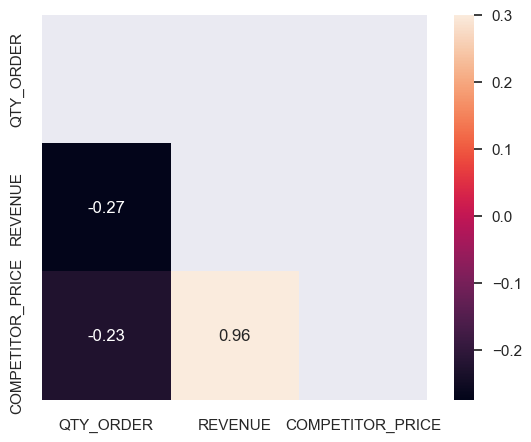

In [54]:
f, ax = plt.subplots(figsize=(7, 5))
mask = np.zeros_like(df.corr())
mask[np.triu_indices_from(mask)] = True
sns.heatmap(df.corr(), ax=ax, mask=mask, vmax=.3, square=True, annot=True)
plt.show()

# K-means

In [55]:
# df2 = df.groupby(['PROD_ID']).agg({'QTY_ORDER': ['median'], 'REVENUE': ['median'], 'COMPETITOR_PRICE': ['median']}).reset_index()
df2 = df.groupby(['PROD_ID']).agg({'QTY_ORDER': ['mean'], 'REVENUE': ['mean']}).reset_index()
df2.columns = df2.columns.get_level_values(0)
df2_prodid = df2["PROD_ID"]
df2 = df2.drop(columns=["PROD_ID"])
df2
# 

,QTY_ORDER,REVENUE
0,16.559524,1389.565516
1,236.390244,671.127526
2,11.796000,1248.940240
3,86.979899,495.554121
4,115.054645,823.385137
5,14.814685,1751.607133
6,742.884211,678.941719
7,142.000000,429.137238
8,93.623810,436.912619


In [56]:
# df2 = df.drop(columns=["PROD_ID", "DATE_ORDER"])

scaler = MinMaxScaler()
scaler.fit(df2)
scaled_df = scaler.transform(df2)
scaled_df = pd.DataFrame(scaled_df, columns=df2.columns)
scaled_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   QTY_ORDER  9 non-null      float64
 1   REVENUE    9 non-null      float64
dtypes: float64(2)
memory usage: 272.0 bytes


In [57]:
inertias = []
for i in range(1,8):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(scaled_df)
    inertias.append(kmeans.inertia_)
    print(f"n_clusters= {i}, inertia={kmeans.inertia_}")
    

n_clusters= 1, inertia=1.8116837367495846
n_clusters= 2, inertia=0.7537323270893713
n_clusters= 3, inertia=0.17171227124234772
n_clusters= 4, inertia=0.10045655482841565
n_clusters= 5, inertia=0.030957364771063336
n_clusters= 6, inertia=0.010557448386687405
n_clusters= 7, inertia=0.0048826199996173285


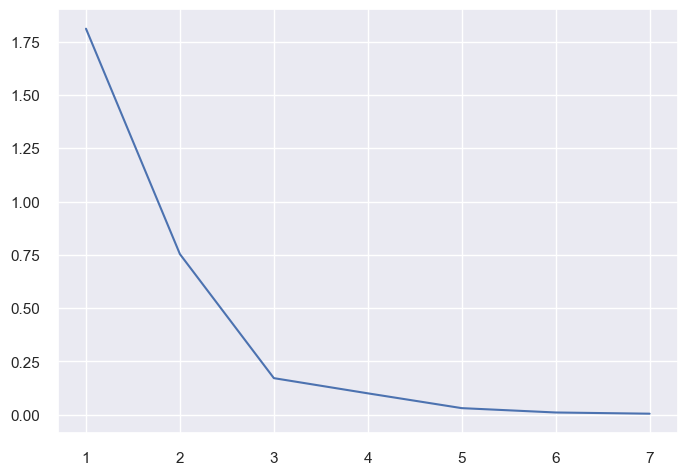

In [58]:
sns.lineplot(y=inertias, x=range(1,8))
plt.show()

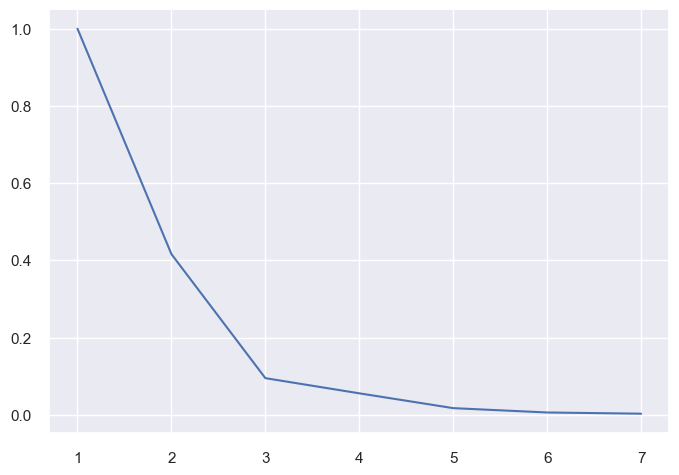

In [59]:
inertias_pct = [w/inertias[0] for w in inertias]
sns.lineplot(y=inertias_pct, x=range(1,8))
plt.show()

In [60]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(scaled_df)
cluster_label = kmeans.predict(scaled_df)
df2["LABEL"] = cluster_label

df2 = pd.concat([df2_prodid, df2], axis=1)
df2


,PROD_ID,QTY_ORDER,REVENUE,LABEL
0,P1,16.559524,1389.565516,0
1,P2,236.390244,671.127526,1
2,P3,11.796000,1248.940240,0
3,P4,86.979899,495.554121,1
4,P5,115.054645,823.385137,1
5,P6,14.814685,1751.607133,0
6,P7,742.884211,678.941719,2
7,P8,142.000000,429.137238,1
8,P9,93.623810,436.912619,1


In [61]:
label = [] 
for prod in df['PROD_ID'].values:
    label.append(int(df2['LABEL'].loc[df2['PROD_ID'] == prod].values[0]))

df['LABEL'] = label
df

,PROD_ID,DATE_ORDER,QTY_ORDER,REVENUE,COMPETITOR_PRICE,LABEL
0,P1,2015-02-04,10.0,1499.00,NaN,0
1,P1,2015-02-05,12.0,1349.10,NaN,0
2,P1,2015-02-06,21.0,1349.10,NaN,0
3,P1,2015-02-07,4.0,1499.00,NaN,0
4,P1,2015-02-08,7.0,1499.00,NaN,0
...,...,...,...,...,...,...
2157,P9,2015-10-10,129.0,388.89,395.82,1
2158,P9,2015-10-11,87.0,388.66,395.82,1
2159,P9,2015-10-12,110.0,388.63,395.76,1
2160,P9,2015-10-13,328.0,341.10,393.00,1


In [62]:
df2.groupby(["LABEL"]).count()

,PROD_ID,QTY_ORDER,REVENUE
LABEL,,,
0,3,3,3
1,5,5,5
2,1,1,1


# Exploratory Analysis

## Outliers

In [63]:
base = 'PROD_ID'

for b in df[base].unique():
    n,m = df["REVENUE"][np.abs(zscore(df["REVENUE"])) > 3].loc[df[base] == b].index, 'REVENUE'
    if len(n):
        for i in n:
            df.at[int(i),m] = df['REVENUE'].loc[df[base] == b].mean()

    n,m = df["QTY_ORDER"][np.abs(zscore(df["QTY_ORDER"])) > 3].loc[df[base] == b].index, 'QTY_ORDER'
    if len(n):
        for i in n:
            df.at[int(i),m] = df['QTY_ORDER'].loc[df[base] == b].mean()
    
    n,m = df['COMPETITOR_PRICE'].loc[(np.isnan(df['COMPETITOR_PRICE'])) & (df[base] == b)].index, 'COMPETITOR_PRICE'
    if len(n):
        for i in n:
            df.at[int(i),m] = df['REVENUE'].iloc[int(i)]


last_revenue = []

for prod in df['PROD_ID'].unique():
    last_revenue = last_revenue + list(df['REVENUE'].loc[df['PROD_ID'] == prod].shift(periods=-1).values)

df['LAST_REVENUE'] = last_revenue
df['LAST_REVENUE'] = df['LAST_REVENUE'].fillna(0)


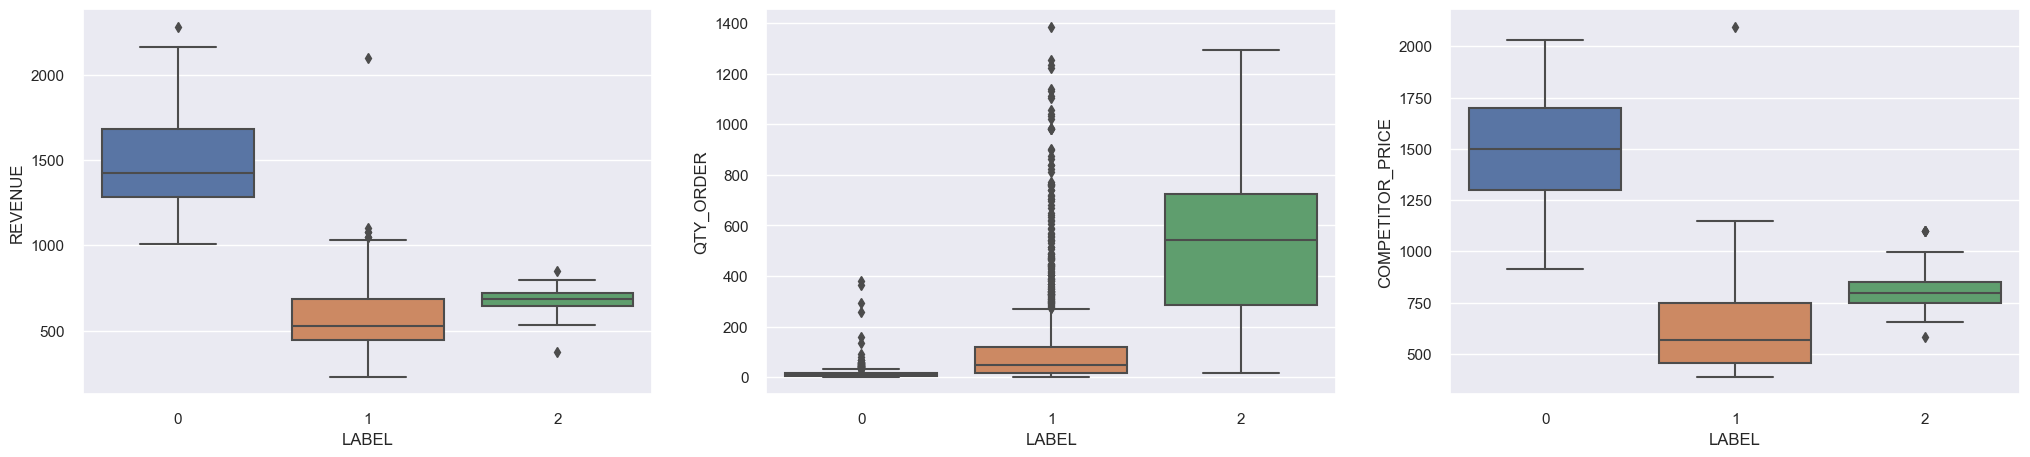

In [64]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(25,5))

sns.boxplot(data=df, x='LABEL', y='REVENUE', ax=ax[0])
sns.boxplot(data=df, x='LABEL', y='QTY_ORDER', ax=ax[1])
sns.boxplot(data=df, x='LABEL', y='COMPETITOR_PRICE', ax=ax[2])
plt.show()

In [65]:
df

,PROD_ID,DATE_ORDER,QTY_ORDER,REVENUE,COMPETITOR_PRICE,LABEL,LAST_REVENUE
0,P1,2015-02-04,10.0,1499.00,1499.00,0,1349.10
1,P1,2015-02-05,12.0,1349.10,1349.10,0,1349.10
2,P1,2015-02-06,21.0,1349.10,1349.10,0,1499.00
3,P1,2015-02-07,4.0,1499.00,1499.00,0,1499.00
4,P1,2015-02-08,7.0,1499.00,1499.00,0,1424.05
...,...,...,...,...,...,...,...
2157,P9,2015-10-10,129.0,388.89,395.82,1,388.66
2158,P9,2015-10-11,87.0,388.66,395.82,1,388.63
2159,P9,2015-10-12,110.0,388.63,395.76,1,341.10
2160,P9,2015-10-13,328.0,341.10,393.00,1,341.10


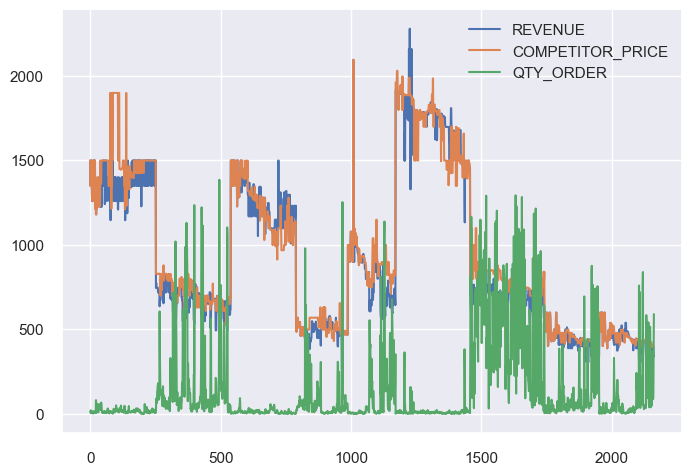

In [66]:
df[['REVENUE', 'COMPETITOR_PRICE', 'QTY_ORDER']].plot()
plt.show()

# Criando features

In [67]:
X = df.drop(columns=["QTY_ORDER", 'PROD_ID', 'DATE_ORDER'])
y = df["QTY_ORDER"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.15)

## Linear Regression

In [68]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [69]:
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)
print(r2_score(y_train, y_pred_train))
print(r2_score(y_test, y_pred))

0.4510463576508945
0.40551085090385075


In [70]:
for cluster in df['LABEL'].unique():
    X = df.drop(columns=["QTY_ORDER", 'PROD_ID', 'DATE_ORDER', 'LABEL']).loc[df['LABEL'] == cluster]
    y = df["QTY_ORDER"].loc[df['LABEL'] == cluster]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.15)

    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    print("Cluster label train",cluster, ": ",r2_score(y_train, y_pred_train))
    print("Cluster label pred",cluster, ": ",r2_score(y_test, y_pred))

Cluster label train 0 :  0.09653108312112246
Cluster label pred 0 :  -0.23271299470271
Cluster label train 1 :  0.29665489907917364
Cluster label pred 1 :  0.2863790102637088
Cluster label train 2 :  0.22063460910784305
Cluster label pred 2 :  0.025970705322389986


## Polinomial Regression

In [71]:
X = df.drop(columns=["QTY_ORDER", 'PROD_ID', 'DATE_ORDER', 'LABEL'])
y = df["QTY_ORDER"]

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [73]:
poly = PolynomialFeatures(degree = 4) 
X_poly = poly.fit_transform(X_train) 
poly.fit(X_poly, y_train) 

PolynomialFeatures(degree=4)

In [74]:
lm = linear_model.LinearRegression() 
lm.fit(X_poly, y_train) 

LinearRegression()

In [75]:
predictions = lm.predict(poly.fit_transform(X_test))
print('r2_score= ', metrics.r2_score(y_test, predictions))

r2_score=  0.43508951900776727


In [76]:
X_train

,REVENUE,COMPETITOR_PRICE,LAST_REVENUE
1313,1829.00,1869.90,1828.99
1172,1914.80,1959.90,1914.80
335,744.93,699.00,744.93
856,529.00,569.00,529.00
2156,355.41,395.85,388.89
...,...,...,...
434,676.90,698.89,678.00
458,719.89,664.05,719.89
2098,388.50,441.00,431.67
604,1299.00,1349.00,1299.00


## XGBoost

In [77]:
# fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20,6))

cluster = 0
lbl = df['LABEL'] == cluster

X = df.drop(columns=["QTY_ORDER", 'PROD_ID', 'DATE_ORDER', 'LABEL']).loc[lbl]
y = df["QTY_ORDER"].loc[lbl]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

model = XGBRegressor(max_depth=2)
model.fit(X_train.loc[lbl], y_train.loc[lbl])
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)
print("Cluster label train",cluster, ": ",r2_score(y_train, y_pred_train))
print("Cluster label pred",cluster, ": ",r2_score(y_test, y_pred))
print("mean_absolute_percentage_error pred:", mean_absolute_percentage_error(y_test, y_pred))
print("mean_absolute_percentage_error train:", mean_absolute_percentage_error(y_train, y_pred_train))
print("-------------")

# #----------------------------------------------------------------------------------------------------------

cluster = 1
lbl = df['LABEL'] == cluster

X = df.drop(columns=["QTY_ORDER", 'PROD_ID', 'DATE_ORDER', 'LABEL']).loc[lbl]
y = df["QTY_ORDER"].loc[lbl]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

model2 = XGBRegressor(max_depth=2)
model2.fit(X_train, y_train)
y_pred = model2.predict(X_test)
y_pred_train = model2.predict(X_train)
print("Cluster label train",cluster, ": ",r2_score(y_train, y_pred_train))
print("Cluster label pred",cluster, ": ",r2_score(y_test, y_pred))
print("mean_absolute_percentage_error pred:", mean_absolute_percentage_error(y_test, y_pred))
print("mean_absolute_percentage_error train:", mean_absolute_percentage_error(y_train, y_pred_train))
print("-------------")

# #----------------------------------------------------------------------------------------------------------

cluster = 2
lbl = df['LABEL'] == cluster

X = df.drop(columns=["QTY_ORDER", 'PROD_ID', 'DATE_ORDER', 'LABEL']).loc[lbl]
y = df["QTY_ORDER"].loc[lbl]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

model3 = XGBRegressor(max_depth=2)
model3.fit(X_train, y_train)
y_pred = model3.predict(X_test)
y_pred_train = model3.predict(X_train)
print("Cluster label train",cluster, ": ",r2_score(y_train, y_pred_train))
print("Cluster label pred",cluster, ": ",r2_score(y_test, y_pred))
print("mean_absolute_percentage_error pred:", mean_absolute_percentage_error(y_test, y_pred))
print("mean_absolute_percentage_error train:", mean_absolute_percentage_error(y_train, y_pred_train))

Cluster label train 0 :  0.9201031479952997
Cluster label pred 0 :  -0.13798528496732465
mean_absolute_percentage_error pred: 1.0110128390653201
mean_absolute_percentage_error train: 0.8489928452211553
-------------
Cluster label train 1 :  0.7410811943787735
Cluster label pred 1 :  0.5245885608707728
mean_absolute_percentage_error pred: 2.502419486599562
mean_absolute_percentage_error train: 1.4498983035058346
-------------
Cluster label train 2 :  0.6660578738507018
Cluster label pred 2 :  0.37358632489981325
mean_absolute_percentage_error pred: 0.8542514949989403
mean_absolute_percentage_error train: 0.43793326716305897


# Sarimax

# Prophet 

In [78]:
X = df.drop(columns=["QTY_ORDER", 'PROD_ID', 'DATE_ORDER', 'LABEL'])
y = df["QTY_ORDER"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

In [79]:
df[['DATE_ORDER', 'REVENUE']]

,DATE_ORDER,REVENUE
0,2015-02-04,1499.00
1,2015-02-05,1349.10
2,2015-02-06,1349.10
3,2015-02-07,1499.00
4,2015-02-08,1499.00
...,...,...
2157,2015-10-10,388.89
2158,2015-10-11,388.66
2159,2015-10-12,388.63
2160,2015-10-13,341.10


In [80]:
m = Prophet()
p = df[['DATE_ORDER', 'REVENUE']].rename(columns={'DATE_ORDER': 'ds', 'REVENUE': 'y'})

m.fit(p.loc[df['PROD_ID'] == "P1"])

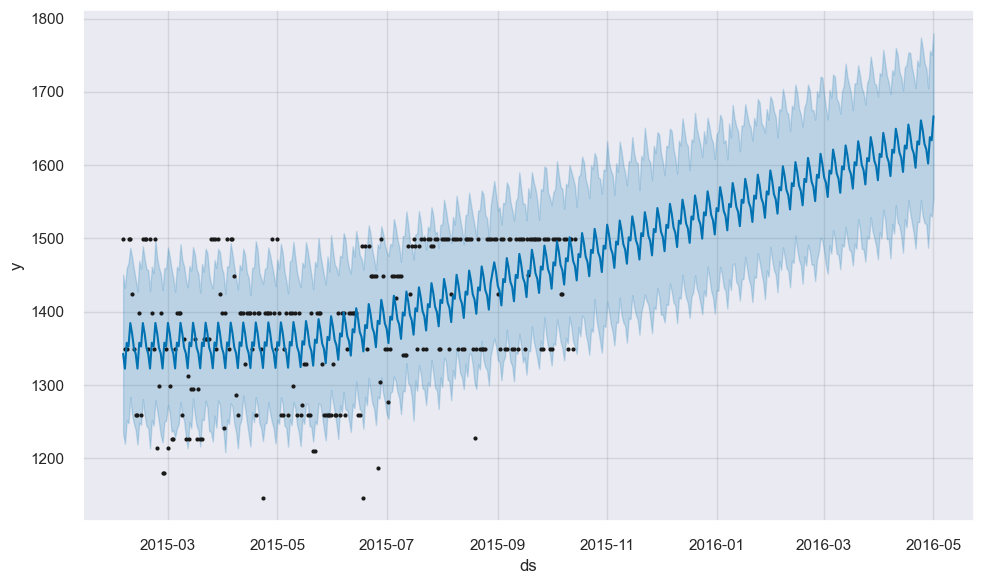

In [81]:
future = m.make_future_dataframe(periods=200)
forecast = m.predict(future)
fig1 = m.plot(forecast)
plt.show()

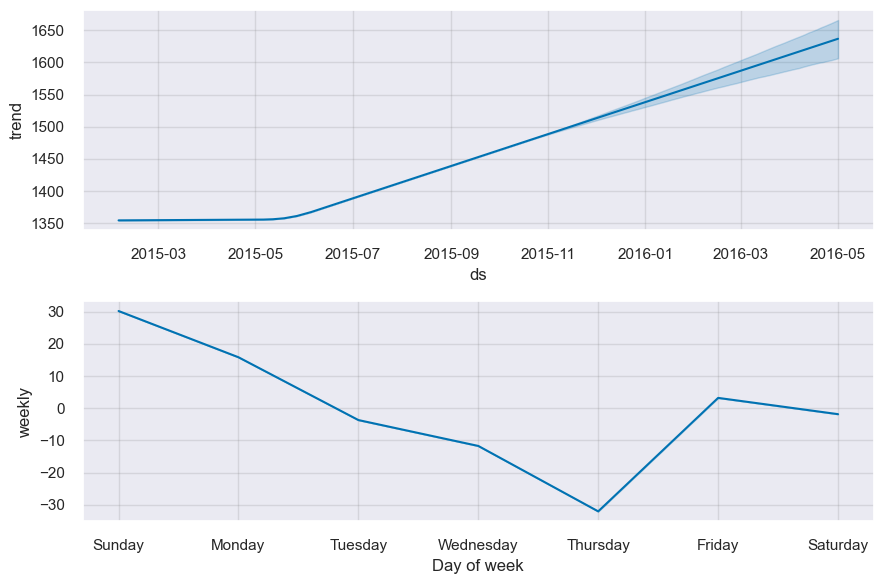

In [82]:
fig2 = m.plot_components(forecast)
plt.show()

In [83]:
from auto_ts import auto_timeseries


In [84]:
model = auto_timeseries( score_type='rmse', 
                            time_interval='D', 
                            non_seasonal_pdq=None, 
                            seasonality=False, 
                            seasonal_period=14, 
                            model_type='best', verbose=2)



In [85]:
df_tst = df.loc[df['PROD_ID'] == 'P2']
df_tst = df_tst.drop(['PROD_ID', 'LABEL', 'LAST_REVENUE'], axis=1)
df_tst

,DATE_ORDER,QTY_ORDER,REVENUE,COMPETITOR_PRICE
252,2015-01-01,23.0,746.10,829.00
253,2015-01-02,90.0,774.20,829.00
254,2015-01-03,69.0,746.10,829.00
255,2015-01-04,63.0,746.10,829.00
256,2015-01-05,98.0,746.10,829.00
...,...,...,...,...
534,2015-10-10,41.0,616.23,649.90
535,2015-10-11,25.0,616.23,649.90
536,2015-10-12,52.0,587.23,699.00
537,2015-10-13,49.0,619.86,699.00


Start of Fit.....
Running Augmented Dickey-Fuller test with paramters:
    maxlag: 31 regression: c autolag: BIC
Results of Augmented Dickey-Fuller Test:
+-----------------------------+------------------------------+
|                             | Dickey-Fuller Augmented Test |
+-----------------------------+------------------------------+
|        Test Statistic       |      -8.775217985748585      |
|           p-value           |    2.4593096252849658e-14    |
|          #Lags Used         |             0.0              |
| Number of Observations Used |            286.0             |
|     Critical Value (1%)     |     -3.4534232986669546      |
|     Critical Value (5%)     |     -2.8716994185534745      |
|     Critical Value (10%)    |     -2.5721833625116144      |
+-----------------------------+------------------------------+
 this series is stationary
    Target variable given as = QTY_ORDER
Start of loading of data.....
Input is data frame. Performing Time Series Analysis
ts

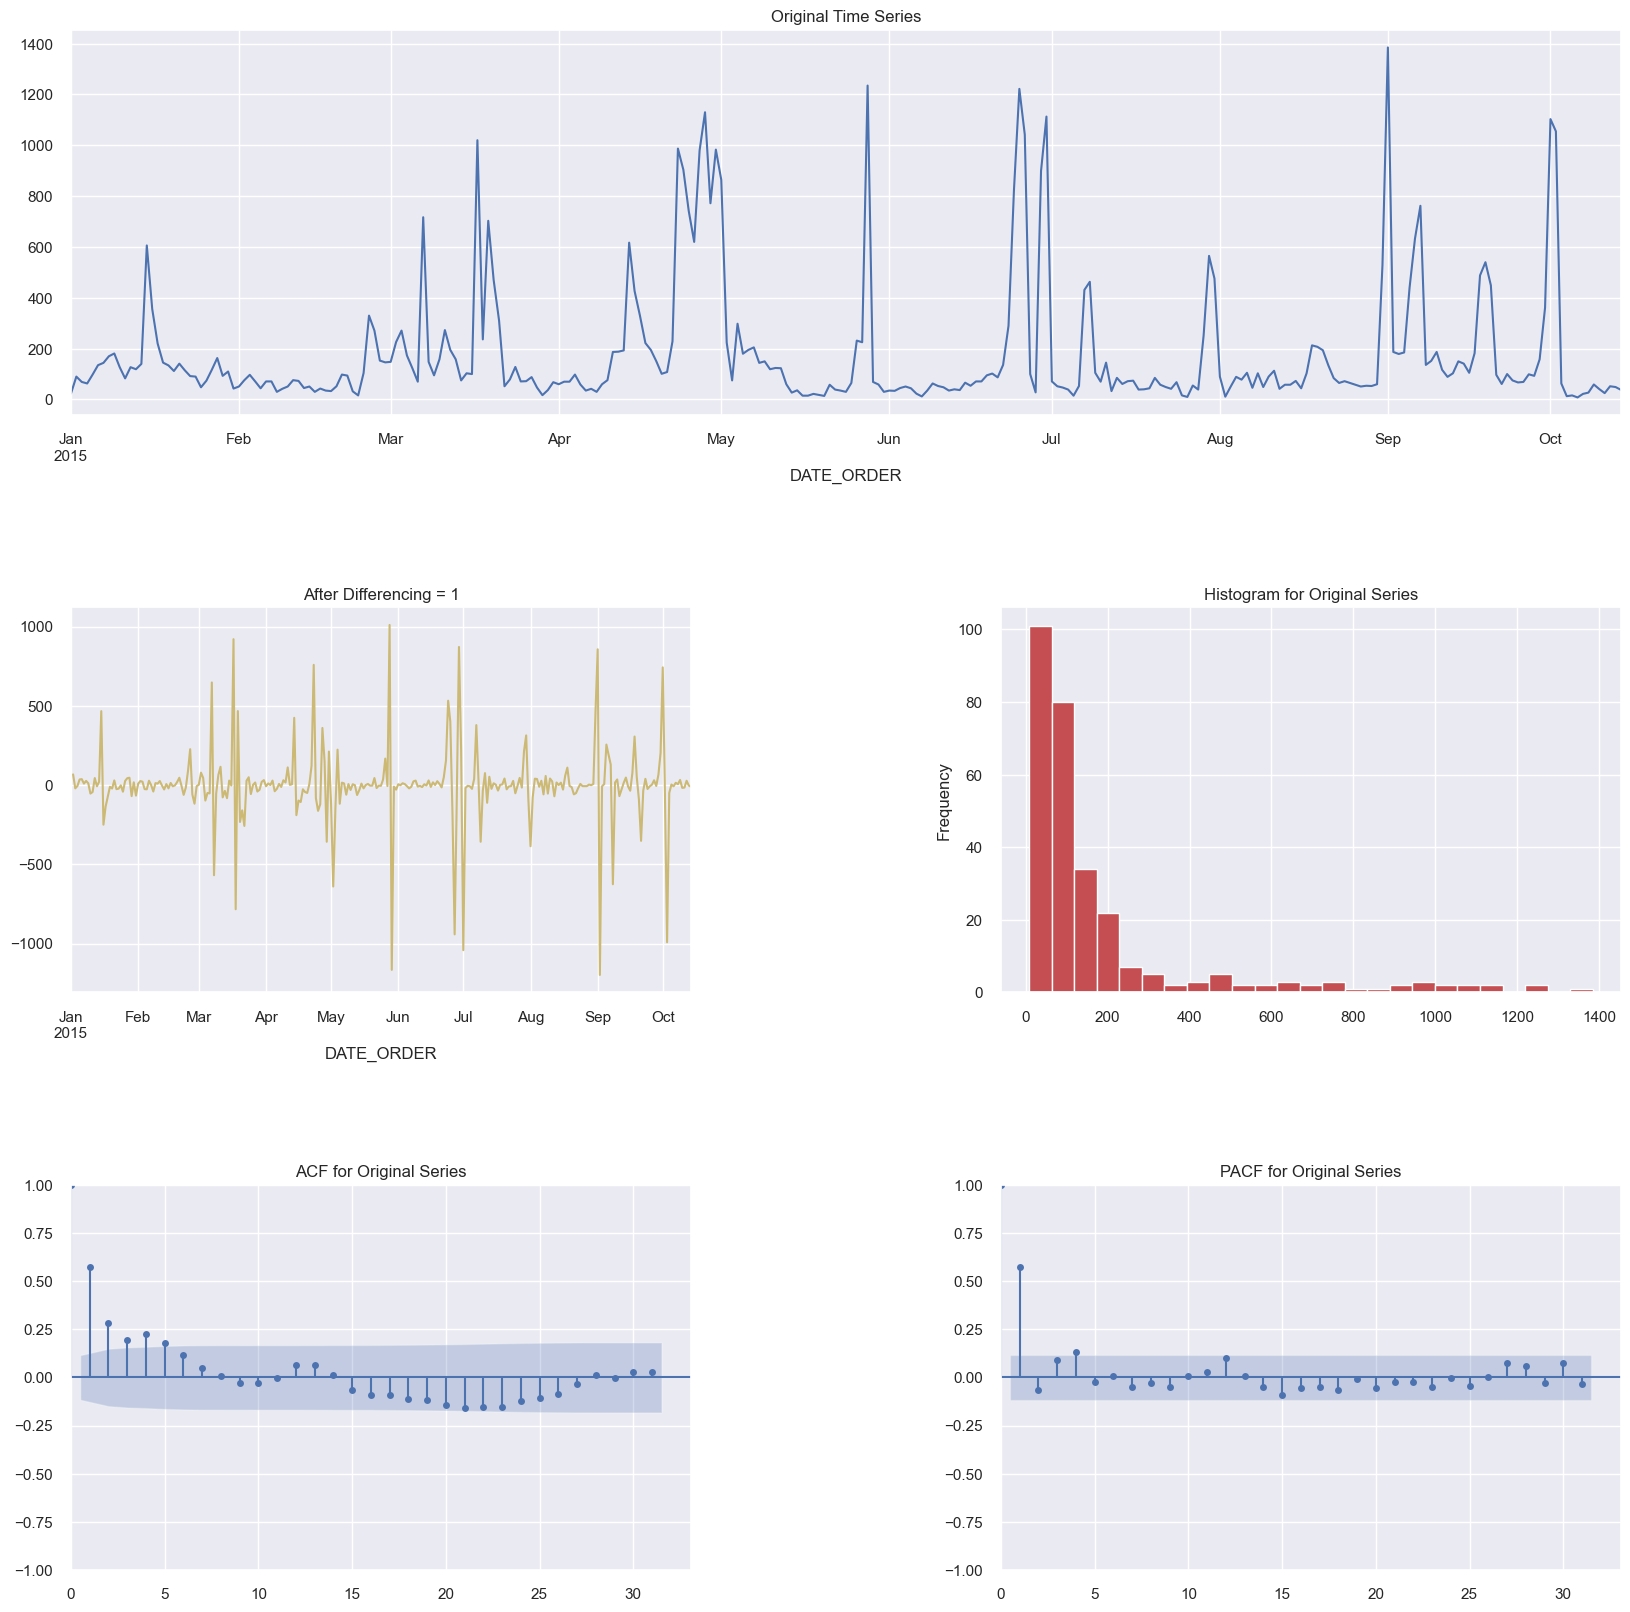

Time Interval is given as D
    Correct Time interval given as a valid Pandas date-range frequency...


Building Prophet Model



Running Facebook Prophet Model...
    Fit-Predict data (shape=(287, 4)) with Confidence Interval = 0.95...
  Starting Prophet Fit
      No seasonality assumed since seasonality flag is set to False
  Starting Prophet Cross Validation
Max. iterations using expanding window cross validation = 5

Fold Number: 1 --> Train Shape: 262 Test Shape: 5
    Root Mean Squared Error predictions vs actuals = 208.28
    Std Deviation of actuals = 147.00
    Normalized RMSE = 142%
Cross Validation window: 1 completed

Fold Number: 2 --> Train Shape: 267 Test Shape: 5
    Root Mean Squared Error predictions vs actuals = 112.12
    Std Deviation of actuals = 32.94
    Normalized RMSE = 340%
Cross Validation window: 2 completed

Fold Number: 3 --> Train Shape: 272 Test Shape: 5
    Root Mean Squared Error predictions vs actuals = 541.46
    Std Deviation of actuals = 472.71
  

In [86]:
model.fit( traindata=df_tst, ts_column='DATE_ORDER', target='QTY_ORDER', cv=5 )

In [87]:
model.get_leaderboard()

,name,rmse
1,auto_SARIMAX,222.237987
2,VAR,235.829831
0,Prophet,248.940087
3,ML,378.992167


In [90]:
results_dict = model.get_ml_dict()